In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def simulateBM(S0, ts, Ntraj):
    '''
    Simulates trajectories of Brownian Motion
    Input
    float S0 -- initial value
    float[] ts -- times
    int Ntraj -- number of trajectories to simulate
    Returns
    float[] of shape (Ntraj,len(ts))
    '''
    St=np.zeros([Ntraj,len(ts)])
    St[...,0]=S0

    for kk in np.arange(1,len(ts)):
        #generate Ntraj of independent standard normal random variables
        noises=np.random.standard_normal(size=(Ntraj))
        St[...,kk] = St[...,kk-1] + noises*np.sqrt(ts[kk]-ts[kk-1])

    return St

In [5]:
def simulateGBM(S0, mu, sigma, ts, Ntraj):
        '''
        Simulates trajectories of GBM with parameters mu and sigma
        Input
        float[] S0 -- initial price, (d,)
        float[] mu -- mu parameter, (d,)
        float[] sigma -- sigma parameter, (d,)
        float[] ts -- times
        int Ntraj -- number of trajectories to simulate
        Returns
        float[] of shape (Ntraj,len(ts)) , trajectories
        '''
        try:
                bms = simulateBM(np.zeros(S0.shape),ts-ts[0],Ntraj)
        except:
                bms = simulateBM(0,ts-ts[0],Ntraj)


        St = S0*np.exp((mu-sigma**2/2)*ts + sigma*bms)
        
        return St

In [174]:
a=0
b=2
Nt=1000
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)

mu=0.05 * np.ones([1])
sigma=0.2 * np.ones([1])
Ntraj=20
S0=5 * np.ones([1])

gbmTrajs = simulateGBM(S0,mu,sigma,ts,Ntraj)
wienTrajs = simulateBM(S0,ts,Ntraj)

In [176]:
gbmTrajs.shape

(20, 1001)

In [21]:
def priceEuropeanCall2(S0, mu, sigma, K, T, NSamples=10):
    '''
    Sets a price on european call option
    Input
    float[] x0 -- current prices, (d,)
    float[] mu -- mu parameter, (d,)
    float[] sigma -- sigma parameter, (d,)
    functionHandler f -- payment function, R^d --> R
    float T -- expiration time
    int NSamples -- number of Monte Carlo samples to use
    '''
    
    #simulate
    r=0
    noises=np.random.standard_normal(size=(Ntraj))
    ST = S0*np.exp((-pow(sigma,2)/2)*T+sigma*sqrt(T)*noises)
    
    last_price = ST
    payments = (last_price-K)*((last_price-K)>0)
    priceMean = np.mean(payments)
    priceStd = np.std(payments)

    return (priceMean, priceStd)

In [11]:
d=1
mu=0.05 * np.ones([d])
sigma=0.2 * np.ones([d])
S0=15 * np.ones([d])
K=15
T=3

a=0
b=T
Nt=1_000
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)

NSamples=10
xs = simulateGBM(S0, mu, sigma, ts, NSamples)

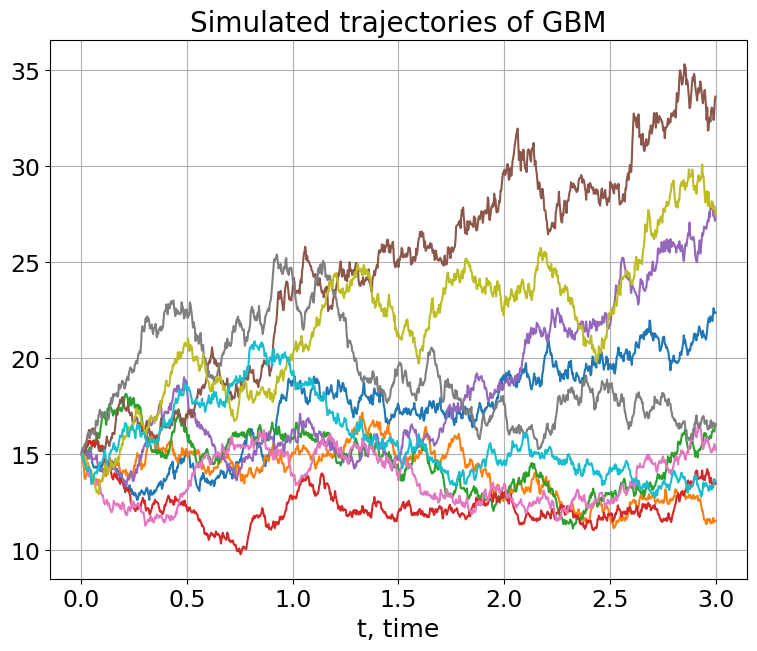

In [68]:
#plots
f, ax = plt.subplots(figsize=(9,7))

ax.grid()
ax.set_title('Simulated trajectories of GBM',fontsize=20)
ax.set_xlabel('t, time',fontsize=18)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)
ax.plot(ts, xs.T)

In [13]:
from scipy.stats import norm
from math import log, exp, sqrt

def priceEuropeanCall_formula(S0, mu, sigma, K, T):
    r=0
    a=S0*np.exp(r*T)
    b=sigma*sqrt(T)
    y1=(np.log(a/K)+(1/2)*pow(b,2)+r*T)/b
    y2=(np.log(a/K)-(1/2)*pow(b,2)+r*T)/b
    return S0*norm.cdf(y1)-K*np.exp((-1)*r*T)*norm.cdf(y2)

In [46]:
d=1
a_f=priceEuropeanCall_formula(S0, mu, sigma, K, T)
a_f

array([2.06264655])

In [334]:
mu

array([0.05])

In [66]:
NSamples = 1_000
priceMean, priceStd = priceEuropeanCall2(S0,mu,sigma, K, T, NSamples)
print(priceMean, "+-", 1.96*priceStd/np.sqrt(NSamples) )

2.0776348612275224 +- 0.2376797213557763


In [155]:
#convergence of MC
#d=1
mu=0.01 * np.ones([d])
#sigma=0.2 * np.ones([d])
#S0=15 * np.ones([d])
#K=15
#T=3
NSamples = 12_000
start = 1_000
experiments = [ {"mu":mu, "sigma":sigma, "x0":S0, "NSamples": nS, "K":K, "T":T} \
                for nS in np.arange(start,NSamples,100)]

results = [ priceEuropeanCall2(experiments[k]["x0"],experiments[k]["mu"],experiments[k]["sigma"], experiments[k]["K"],\
                              experiments[k]["T"], experiments[k]["NSamples"]) for k in np.arange(len(experiments))]

prices= np.array([results[k][0] for k in np.arange(len(results))])
priceStds= np.array([results[k][1] for k in np.arange(len(results))])
NSampless = np.arange(start, NSamples, 100)

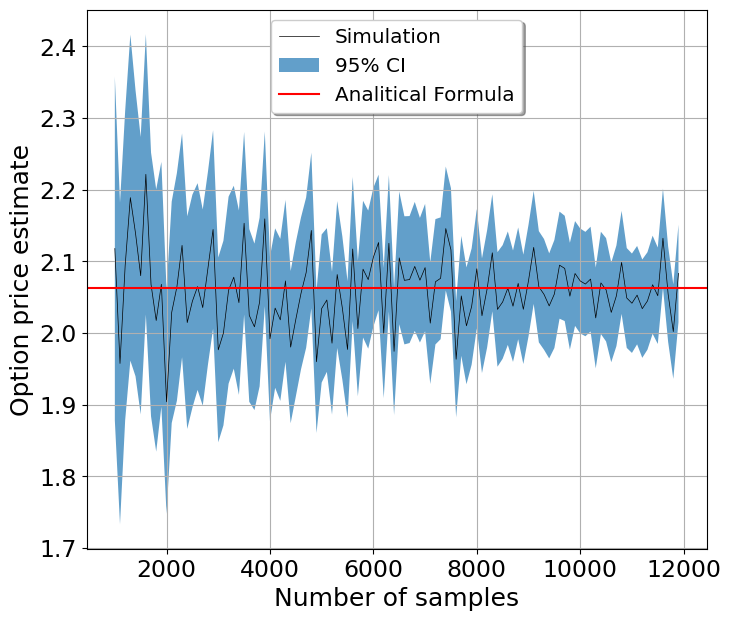

In [163]:
f, ax = plt.subplots(figsize=(8,7))

ax.grid()
#ax.set_title('Convergence of Monte Carlo Pricing',fontsize=20)
ax.set_xlabel('Number of samples',fontsize=18)
ax.set_ylabel('Option price estimate',fontsize=18)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)
ax.plot(NSampless , prices, linewidth=0.5, color='black', label='Simulation')
ax.fill_between(NSampless, prices + 1.96*priceStds/np.sqrt(NSampless),
                prices - 1.96*priceStds/np.sqrt(NSampless),alpha=0.7, label='95% CI')
plt.axhline(y=a_f, color='r', linestyle = '-', label='Analitical Formula')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
#legend.get_frame().set_facecolor('C0')
plt.show()
#ax.set_ylim([0,5])

In [159]:
cnt_in_ci_95 = 0
ci_95_ls = prices - 1.96*priceStds/np.sqrt(NSampless)
ci_95_rs = prices + 1.96*priceStds/np.sqrt(NSampless)
res = ((a_f >= ci_95_ls) & (a_f <= ci_95_rs)) 
sum(res)/len(prices)

0.9636363636363636

In [161]:
sum(res)/len(prices)

0.9636363636363636